## Jupyter notebook to create graphs using data from different linux monitoring tools

In [1]:
import matplotlib.pyplot as plt
import fileinput
import numpy as np
import re

In [2]:
def read_file(file_name):
    lines = list()
    for line in fileinput.input(file_name):
        lines.append(line)
    return lines

In [3]:
def get_tests(lines):
    test = list()
    tests = list()
    
    for i in lines:
        if len(re.findall("#test",i)) > 0:
            tests.append(test)
            test = list()
        else:
            test.append(i)
            
    tests.append(test)
    
    return tests[:4]

In [4]:
def get_memory_values(lines):
    kbmemused = list()
    memusedpercent = list()
    for i in lines:
        _,_,_,kbmemused_,memusedpercent_,_,_,_,_ = i.rstrip().split()
        kbmemused.append(float(kbmemused_))
        memusedpercent.append(float(memusedpercent_))
        
    return (kbmemused,memusedpercent)

In [5]:
def get_memory(lines):    
    kbs = list()
    percents = list()
    for i in get_tests(lines):
        kbmemused,memusedpercent = get_memory_values(i)
        kbmemused,memusedpercent = (max(kbmemused),max(memusedpercent))
        kbs.append(kbmemused)
        percents.append(memusedpercent)
        
    kbs = sorted(kbs)
    percents = sorted(percents)
    
    
    return (sum(kbs[:3])/3,sum(percents[:3])/3)

In [6]:
def get_cpu_times(lines,repetitions):
    idle = list()
    iowait = list()
    for i in lines:
        _,_,_,_,_,_,iowait_,_,idle_= i.rstrip().split()
        iowait.append(float(iowait_))
        idle.append(float(idle_))
    
    return (idle,iowait)

In [17]:
def get_cpu(lines,repetitions):
    totals = list()
    idles = list()
    iowaits = list()
    for i in get_tests(lines):
        idle,iowait = get_cpu_times(i,repetitions)
        total,idle,iowait = (float(len(i))/repetitions,sum(idle)*0.01/repetitions,sum(iowait)*0.01/repetitions)
        totals.append(total)
        idles.append(idle)
        iowaits.append(iowait)
    
    print(totals)
    totals = sorted(totals)
    idles = sorted(idles)
    iowaits = sorted(iowaits)
    return (sum(totals[:3])/3,sum(idles[:3])/3,sum(iowaits[:3])/3)
    

In [18]:
def get_io_values(lines):
    tps = list()
    breads = list()
    bwrtns = list()
    for i in lines:
        _,_,tps_,_,_,breads_,bwrtns_ = i.rstrip().split()
        tps.append(float(tps_))
        breads.append(float(breads_))
        bwrtns.append(float(bwrtns_))
        
    return (tps,breads,bwrtns)

In [19]:
def get_io(lines):
    network = list()
    disk = list()
    for i in get_tests(lines):
        tps,breads,bwrtns = get_io_values(i)
        tps,bwreads  = (sum(tps),sum(breads) + sum(bwrtns) )
        network.append(tps)
        disk.append(bwreads)
    
    network = sorted(network)
    disk = sorted(disk)
    
    return (sum(network)/3,sum(disk)/3)

In [20]:
def create_graphs_cpu_part1(gnuO1,gnuO2,gnuO3,intelO1,intelO2,intelO3,repetitions,graph="time",ybottom=0):
    gnuO1 = read_file(gnuO1)[3:]
    gnuO2 = read_file(gnuO2)[3:]
    gnuO3 = read_file(gnuO3)[3:]
    intelO1 = read_file(intelO1)[3:]
    intelO2 = read_file(intelO2)[3:]
    intelO3 = read_file(intelO3)[3:]
    
    gO1time,gO1idle,gO1iowait = get_cpu(gnuO1,repetitions)
    gO2time,gO2idle,gO2iowait = get_cpu(gnuO2,repetitions)
    gO3time,gO3idle,gO3iowait = get_cpu(gnuO3,repetitions)
    
    
    iO1time,iO1idle,iO1iowait = get_cpu(intelO1,repetitions)
    iO2time,iO2idle,iO2iowait = get_cpu(intelO2,repetitions)
    iO3time,iO3idle,iO3iowait = get_cpu(intelO3,repetitions)

    
    
    x = np.arange(6)
    
    
    time = [gO1time,gO2time,gO3time,iO1time,iO2time,iO3time]
    idle = [gO1idle,gO2idle,gO3idle,iO1idle,iO2idle,iO3idle]
    iowait = [gO1iowait,gO2iowait,gO3iowait,iO1iowait,iO2iowait,iO3iowait]

    if(graph == "time"):
        values = time
    if(graph == "idle"):
        values = idle
    if(graph == "iowait"):
        values = iowait
        
    print(values)

    fig, ax = plt.subplots()
   
    plt.bar(x,values)
    if(ybottom != 0):
        ax.set_ylim(bottom=ybottom)
    plt.xticks(x,("gnuO1","gnuO2","gnuO3","intelO1","intelO2","intelO3"))
    plt.show()
    

In [41]:
create_graphs_cpu_part1('tests/ser/cpu/is.D.gnuO1.txt',
                       'tests/ser/cpu/is.D.gnuO2.txt',
                       'tests/ser/cpu/is.D.gnuO3.txt',
                       'tests/ser/cpu/is.D.intelO1.txt',
                       'tests/ser/cpu/is.D.intelO2.txt',
                       'tests/ser/cpu/is.D.intelO3.txt',
                       1,
                       "time",
                        ybottom=0
                       )

FileNotFoundError: [Errno 2] No such file or directory: 'tests/ser/cpu/is.D.gnuO1.txt'

In [27]:
def create_graphs_memory_part1(gnuO1,gnuO2,gnuO3,intelO1,intelO2,intelO3,repetitions,graph="absolute",ybottom=0):
    gnuO1 = read_file(gnuO1)[3:]
    gnuO2 = read_file(gnuO2)[3:]
    gnuO3 = read_file(gnuO3)[3:]
    intelO1 = read_file(intelO1)[3:]
    intelO2 = read_file(intelO2)[3:]
    intelO3 = read_file(intelO3)[3:]
    
    gO1kb,gO1per = get_memory(gnuO1)
    gO2kb,gO2per = get_memory(gnuO2)
    gO3kb,gO3per = get_memory(gnuO3)

    iO1kb,iO1per = get_memory(intelO1)
    iO2kb,iO2per = get_memory(intelO2)
    iO3kb,iO3per = get_memory(intelO3)
    
    x = np.arange(6)
    
    absolute = [gO1kb,gO2kb,gO3kb,iO1kb,iO2kb,iO3kb]
    percentage = [gO1per,gO2per,gO3per,iO1per,iO2per,iO3per]

    if(graph == "absolute"):
        values = absolute
    if(graph == "percentage"):
        values = percentage
        
    fig, ax = plt.subplots()
    plt.bar(x,values)
    if(ybottom != 0):
        ax.set_ylim(bottom=ybottom)
    plt.xticks(x,("gnuO1","gnuO2","gnuO3","intelO1","intelO2","intelO3"))
    plt.show()

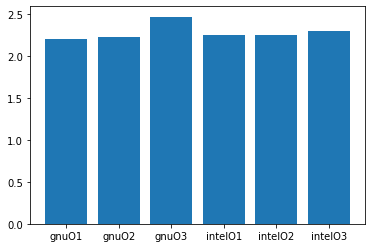

In [31]:
create_graphs_memory_part1('tests/ser/memory/mg.B.gnuO1.txt',
                       'tests/ser/memory/mg.B.gnuO2.txt',
                       'tests/ser/memory/mg.B.gnuO3.txt',
                       'tests/ser/memory/mg.B.intelO1.txt',
                       'tests/ser/memory/mg.B.intelO2.txt',
                       'tests/ser/memory/mg.B.intelO3.txt',
                       1,
                       "percentage",
                        ybottom=0
                        )

In [32]:
def create_graphs_io_part1(gnuO1,gnuO2,gnuO3,intelO1,intelO2,intelO3,repetitions,graph="tcp",ybottom=0):
    gnuO1 = read_file(gnuO1)[3:]
    gnuO2 = read_file(gnuO2)[3:]
    gnuO3 = read_file(gnuO3)[3:]
    intelO1 = read_file(intelO1)[3:]
    intelO2 = read_file(intelO2)[3:]
    intelO3 = read_file(intelO3)[3:]
    
    gO1tcp,gO1disk = get_io(gnuO1)
    gO2tcp,gO2disk = get_io(gnuO2)
    gO3tcp,gO3disk = get_io(gnuO3)

    iO1tcp,iO1disk = get_io(intelO1)
    iO2tcp,iO2disk = get_io(intelO2)
    iO3tcp,iO3disk = get_io(intelO3)
    
    x = np.arange(6)
    
    tcp = [gO1tcp,gO2tcp,gO3tcp,iO1tcp,iO2tcp,iO3tcp]
    disk = [gO1disk,gO2disk,gO3disk,iO1disk,iO2disk,iO3disk]

    if(graph == "tcp"):
        values = tcp
    if(graph == "disk"):
        values = disk
        
    fig, ax = plt.subplots()
    plt.bar(x,values)
    if(ybottom != 0):
        ax.set_ylim(bottom=ybottom)
    plt.xticks(x,("gnuO1","gnuO2","gnuO3","intelO1","intelO2","intelO3"))
    plt.show()

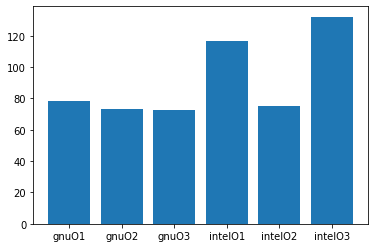

In [36]:
create_graphs_io_part1('tests/ser/io/mg.B.gnuO1.txt',
                       'tests/ser/io/mg.B.gnuO2.txt',
                       'tests/ser/io/mg.B.gnuO3.txt',
                       'tests/ser/io/mg.B.intelO1.txt',
                       'tests/ser/io/mg.B.intelO2.txt',
                       'tests/ser/io/mg.B.intelO3.txt',
                       1,
                       "tcp")

In [114]:
lines_cpu_gnuO1 = read_file('tests/omp/cpu/mg_D_gnuO1.txt')
lines_cpu_gnuO2 = read_file('tests/omp/cpu/mg_D_gnuO2.txt')
lines_cpu_gnuO3 = read_file('tests/omp/cpu/mg_D_gnuO3.txt')

lines_memory_gnuO1 = read_file('tests/omp/memory/mg_D_gnuO1.txt')
lines_memory_gnuO2 = read_file('tests/omp/memory/mg_D_gnuO2.txt')
lines_memory_gnuO3 = read_file('tests/omp/memory/mg_D_gnuO3.txt')

lines_io_gnuO1 = read_file('tests/omp/io/mg_D_gnuO1.txt')
lines_io_gnuO2 = read_file('tests/omp/io/mg_D_gnuO2.txt')
lines_io_gnuO3 = read_file('tests/omp/io/mg_D_gnuO3.txt')

In [117]:
get_cpu_times(lines_cpu[3:],1)
print(get_cpu(lines_cpu_gnuO1[3:],1))
print(get_cpu(lines_cpu_gnuO2[3:],1))
print(get_cpu(lines_cpu_gnuO3[3:],1))

print(get_memory(lines_memory_gnuO1[3:]))
print(get_memory(lines_memory_gnuO2[3:]))
print(get_memory(lines_memory_gnuO3[3:]))

print(get_io(lines_io_gnuO1[3:]))
print(get_io(lines_io_gnuO2[3:]))
print(get_io(lines_io_gnuO3[3:]))

(849.0, 46.63590000000006, 0.0262)
(832.0, 40.50200000000002, 0.0206)
(844.0, 56.764199999999995, 0.010399999999999998)
(29059060.0, 43.98)
(29060160.0, 43.98)
(28851848.0, 43.67)
(200.09999999999997, 1600.8199999999997)
(199.81, 1598.53)
(197.03, 1576.25)


In [67]:
linesO3 = read_file('tests/omp/cpu/ep_D_gnuO3.txt')
linesO2 = read_file('tests/omp/cpu/ep_D_gnuO2.txt')
linesO1 = read_file('tests/omp/cpu/ep_D_gnuO1.txt')


In [68]:
O3 = [len(x) for x in get_tests(linesO3[3:])]
O2 = [len(x) for x in get_tests(linesO2[3:])]
O1 = [len(x) for x in get_tests(linesO1[3:])]

print(sum(O1))
print(sum(O2))
print(sum(O3))

741
711
938
